<a href="https://colab.research.google.com/github/jumacaq/Brain_tumor_detection/blob/main/tumor_detection_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bloque 1: Configuración Inicial y Carga de Datos 📂

Comenzamos importando las herramientas necesarias. Aunque se utilizan varias librerías para el análisis, visualización y métricas, **TensorFlow** (junto con su API Keras) es el pilar para la construcción y entrenamiento de nuestro modelo de Deep Learning. También se emplean librerías como Pandas para la manipulación de datos y OS para interactuar con el sistema de archivos.


##1.1 Importación de Librerías Esenciales

In [ ]:
!python --version

Python 3.11.13


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Librerías de Scikit-learn para preprocesamiento y métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Imbalanced-learn para manejar desbalance de clases
#from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Componentes de TensorFlow y Keras
import tensorflow as tf
tf.get_logger().setLevel('ERROR')# Suprime mensajes informativos de TensorFlow, mostrando solo errores
tf.autograph.set_verbosity(0)
from tensorflow import keras
from keras import layers, Model, callbacks
from keras.api.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.api.applications import ResNet50 # El modelo base que usaremos
from keras.api.applications.resnet import preprocess_input # Función de preprocesamiento específica para ResNet
from keras.api.metrics import AUC # Métrica de Área Bajo la Curva ROC

# Configuración para la visualización y logs de TensorFlow
sns.set_style("whitegrid") # Estilo para los gráficos de Seaborn


In [ ]:
tf.__version__

'2.18.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 1.2 Definición de Rutas y Carga de Datos
Las imágenes se encuentran almacenadas en un directorio local, estructurado con subcarpetas que representan cada una de las clases (categorías) de nuestro problema de clasificación.
- **base_path:** Es el directorio raíz que contiene las subcarpetas de las categorías.
- **categories:** Una lista con los nombres de las subcarpetas, que corresponden a nuestras etiquetas de clase (ej. "Healthy", "Tumor").

In [ ]:
base_path = "/content/drive/MyDrive/Brain_tumor_detection/image"  # Directorio raíz donde se encuentran las carpetas de categorías
categories = ["Healthy", "Tumor"] # Nombres de las subcarpetas y nuestras clases

image_paths = []  # Lista para almacenar las rutas a cada imagen
labels = []       # Lista para almacenar la etiqueta de cada imagen

# Iterar sobre cada categoría definida
for category in categories:
    category_path = os.path.join(base_path, category) # Construir la ruta a la carpeta de la categoría
    if os.path.isdir(category_path):
        # Iterar sobre cada archivo de imagen dentro de la carpeta de la categoría
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name) # Ruta completa a la imagen
            image_paths.append(image_path) # Añadir la ruta de la imagen a la lista
            labels.append(category)        # Añadir la etiqueta (nombre de la categoría) a la lista
    else:
        print(f"Advertencia: El directorio para la categoría '{category}' no fue encontrado en '{category_path}'")


In [ ]:
# Crear un DataFrame de Pandas para almacenar las rutas de las imágenes y sus etiquetas
df = pd.DataFrame({"image_path": image_paths, "label": labels})
# Mostrar las primeras filas del DataFrame y la distribución de clases
print("DataFrame inicial con rutas de imágenes y etiquetas:")
print(df.head())
print("\nDistribución de clases inicial:")
print(df['label'].value_counts())

DataFrame inicial con rutas de imágenes y etiquetas:
                                          image_path    label
0  /content/drive/MyDrive/Brain_tumor_detection/i...  Healthy
1  /content/drive/MyDrive/Brain_tumor_detection/i...  Healthy
2  /content/drive/MyDrive/Brain_tumor_detection/i...  Healthy
3  /content/drive/MyDrive/Brain_tumor_detection/i...  Healthy
4  /content/drive/MyDrive/Brain_tumor_detection/i...  Healthy

Distribución de clases inicial:
label
Tumor      3000
Healthy    2000
Name: count, dtype: int64


# Bloque 2 : Preprocesamiento_de_Datos

## 2.1 Codificación de Etiquetas

In [ ]:
# %% Preprocesamiento
# Codificación de etiquetas
label_encoder = LabelEncoder()
# Se crea una nueva columna 'category_encoded' con las etiquetas numéricas (ej. 0 para Healthy, 1 para Tumor)
df['category_encoded'] = label_encoder.fit_transform(df['label'])

print("DataFrame después de la codificación de etiquetas:")
print(df.head())
print(f"Clases codificadas: {label_encoder.classes_} -> {label_encoder.transform(label_encoder.classes_)}")

DataFrame después de la codificación de etiquetas:
                                          image_path    label  \
0  /content/drive/MyDrive/Brain_tumor_detection/i...  Healthy   
1  /content/drive/MyDrive/Brain_tumor_detection/i...  Healthy   
2  /content/drive/MyDrive/Brain_tumor_detection/i...  Healthy   
3  /content/drive/MyDrive/Brain_tumor_detection/i...  Healthy   
4  /content/drive/MyDrive/Brain_tumor_detection/i...  Healthy   

   category_encoded  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
Clases codificadas: ['Healthy' 'Tumor'] -> [0 1]


## 2.2 División de Datos

In [ ]:
# Primero, dividir en entrenamiento (80%) y un conjunto temporal (20% para validación + prueba)
X_train_original, X_temp, y_train_original, y_temp = train_test_split(
    df[['image_path']],  # Características (rutas de imagen como DataFrame)
    df['category_encoded'], # Etiquetas numéricas
    train_size=0.8,         # 80% para entrenamiento
    shuffle=True,           # Mezclar los datos antes de dividir
    random_state=42,        # Para reproducibilidad
    stratify=df['category_encoded'] # Asegurar proporciones de clase similares en la división
)

# Luego, dividir el conjunto temporal en validación (50% de temp -> 10% del total)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,                 # DataFrame con rutas de imagen del conjunto temporal
    y_temp,                 # Etiquetas del conjunto temporal
    test_size=0.5,          # 50% de X_temp para el conjunto de prueba (el resto para validación)
    shuffle=True,
    random_state=42,
    stratify=y_temp         # Estratificar sobre las etiquetas del conjunto temporal
)

## 2.3 Creación de DataFrames para los Generadores

In [ ]:
# train_df utilizará los datos de entrenamiento sobremuestreados.
train_df = pd.DataFrame(X_train_original, columns=['image_path'])
train_df['category_encoded'] = y_train_original.astype(str)

# valid_df y test_df utilizan los datos originales de validación y prueba, sin sobremuestreo.
valid_df = pd.DataFrame(X_valid, columns=['image_path'])
valid_df['category_encoded'] = y_valid.astype(str)

test_df = pd.DataFrame(X_test, columns=['image_path'])
test_df['category_encoded'] = y_test.astype(str)

## 2.4 Configuración de Generadores de Datos para ResNet

In [ ]:
train_df.head()

,image_path,category_encoded
4882,/content/drive/MyDrive/Brain_tumor_detection/i...,1
684,/content/drive/MyDrive/Brain_tumor_detection/i...,0
3228,/content/drive/MyDrive/Brain_tumor_detection/i...,1
2505,/content/drive/MyDrive/Brain_tumor_detection/i...,1
1480,/content/drive/MyDrive/Brain_tumor_detection/i...,0


In [ ]:
# %% Generadores de datos para ResNet
batch_size = 32
img_size = (224, 224)  # ResNet requiere 224x224

## 2.5 Aumentación de Datos para Entrenamiento (train_datagen)

In [ ]:
# Data augmentation para entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Preprocesamiento específico de ResNet
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## 2.6 Preprocesamiento para Validación y Prueba (test_datagen)

In [ ]:
# Solo preprocesamiento para validación y prueba
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

## 2.7 Creación de los Flujos de Datos (flow_from_dataframe)

In [ ]:
# Generador para el conjunto de entrenamiento
train_gen = train_datagen.flow_from_dataframe(
    train_df,                   # DataFrame con datos de entrenamiento (sobremuestreados)
    x_col='image_path',         # Columna con las rutas de las imágenes
    y_col='category_encoded',   # Columna con las etiquetas codificadas (como string)
    target_size=img_size,       # Tamaño al que se redimensionarán las imágenes
    class_mode='binary',        # Para clasificación binaria
    color_mode='rgb',           # Cargar imágenes en color
    shuffle=True,               # Mezclar los datos de entrenamiento en cada época
    batch_size=batch_size
)

# Generador para el conjunto de validación
valid_gen = test_datagen.flow_from_dataframe(
    valid_df,                   # DataFrame con datos de validación (originales)
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,               # Mezclar datos de validación (opcional, pero True en el script)
    batch_size=batch_size
)

# Generador para el conjunto de prueba
test_gen = test_datagen.flow_from_dataframe(
    test_df,                    # DataFrame con datos de prueba (originales)
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,              # IMPORTANTE: No mezclar el conjunto de prueba
    batch_size=batch_size
)



Found 4000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [ ]:
# Obtener un batch de datos del generador de entrenamiento
x_batch, y_batch = next(train_gen)

img_tensor = x_batch[0]
print('Forma de la imagen:', img_tensor.shape)
print('Tipo de dato de la imagen:', img_tensor.dtype)

np.printoptions(precision=2, suppress=True)
print('Valores de la imagen:')
print(img_tensor[:,:,0])# imagen del color rojo

Forma de la imagen: (224, 224, 3)
Tipo de dato de la imagen: float32
Valores de la imagen:
[[-98.939    -98.939    -98.939    ... -97.939    -97.939    -97.939   ]
 [-98.939    -98.939    -98.939    ... -97.939    -97.939    -97.939   ]
 [-98.939    -98.939    -98.939    ... -97.939    -97.939    -97.939   ]
 ...
 [-95.8635   -95.93411  -95.37304  ... -97.939    -97.939    -97.939   ]
 [-95.98336  -95.9462   -95.71165  ... -97.939    -97.939    -97.939   ]
 [-96.25262  -96.89314  -96.736916 ... -97.939    -97.939    -97.939   ]]


# Bloque 3 : Entrenamiento_Modelo_ResNet50

## 3.1 Construcción del Modelo ResNet50

In [ ]:
# %% Construcción del modelo ResNet50
def build_resnet_model(input_shape=(224, 224, 3)):
    # Cargar ResNet50 preentrenada (sin las capas superiores de clasificación de ImageNet)
    base_model = ResNet50(
        include_top=False,      # No incluir la capa densa final de ResNet50
        weights='imagenet',     # Usar pesos pre-entrenados en ImageNet
        input_shape=input_shape # Definir la forma de entrada de las imágenes
    )

    # Congelar las capas del modelo base inicialmente.
    # Sus pesos no se actualizarán durante la primera fase de entrenamiento.
    base_model.trainable = False

    # Construir el modelo completo añadiendo nuestras propias capas encima de ResNet50
    inputs = layers.Input(shape=input_shape) # Capa de entrada
    # Pasar las entradas a través del modelo base.
    x = base_model(inputs, training=False)
    # Reducir la dimensionalidad espacial a un vector por cada mapa de características.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Capa de Dropout para regularización
    # Capa densa final para la clasificación binaria, con activación sigmoide.
    # Se añade regularización L2 al kernel para prevenir el sobreajuste.
    outputs = layers.Dense(1, activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    # Crear el modelo final especificando las entradas y salidas.
    model = Model(inputs, outputs)
    return model

# Instanciar el modelo
model = build_resnet_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 3.2 Compilación del Modelo

In [ ]:
# Compilación del modelo
model.compile(
    optimizer=Adam(learning_rate=1e-3), # Optimizador Adam con una tasa de aprendizaje inicial
    loss='binary_crossentropy',         # Función de pérdida para clasificación binaria
    metrics=['accuracy', AUC(name='auc')] # Métricas a monitorear
)

## 3.3 Definición de Callbacks

In [ ]:
# Callbacks para el entrenamiento
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_auc',        # Métrica a monitorear (AUC en el conjunto de validación)
        patience=5,               # Número de épocas a esperar sin mejora antes de detener
        mode='max',               # Indica que buscamos maximizar la métrica (AUC)
        restore_best_weights=True,# Restaura los pesos del modelo de la mejor época al finalizar
        verbose=1                 # Muestra mensajes cuando el callback se activa
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',       # Métrica a monitorear (pérdida en el conjunto de validación)
        factor=0.1,               # Factor por el cual se reduce la tasa de aprendizaje (new_lr = lr * factor)
        patience=3,               # Número de épocas a esperar sin mejora antes de reducir LR
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_resnet_model.h5',   # Nombre del archivo para guardar el mejor modelo
        monitor='val_auc',        # Métrica que determina si el modelo es "mejor"
        save_best_only=True,      # Guarda solo el modelo si la métrica monitoreada ha mejorado
        mode='max',               # El objetivo es maximizar val_auc
        verbose=1
    )
]

## 3.4 Entrenamiento en Dos Fases

### Fase 1: Entrenar Solo las Capas Nuevas (Clasificador Superior)

In [ ]:
# Fase 1: Entrenar solo las capas nuevas
print("\nEntrenando capas nuevas...")
initial_epochs = 10 # Número de épocas para la primera fase de entrenamiento
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=initial_epochs,
    callbacks=callbacks_list, # Utilizar la lista de callbacks definida
    verbose=1                 # Mostrar barra de progreso e información por época
)


Entrenando capas nuevas...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7279 - auc: 0.7999 - loss: 0.5534 
Epoch 1: val_auc improved from -inf to 0.98149, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 1491s 12s/step - accuracy: 0.7286 - auc: 0.8007 - loss: 0.5523 - val_accuracy: 0.9260 - val_auc: 0.9815 - val_loss: 0.2039 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9046 - auc: 0.9629 - loss: 0.2612
Epoch 2: val_auc improved from 0.98149 to 0.98945, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 545ms/step - accuracy: 0.9046 - auc: 0.9630 - loss: 0.2612 - val_accuracy: 0.9460 - val_auc: 0.9894 - val_loss: 0.1721 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9246 - auc: 0.9739 - loss: 0.2263
Epoch 3: val_auc improved from 0.98945 to 0.99103, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 559ms/step - accuracy: 0.9246 - auc: 0.9739 - loss: 0.2263 - val_accuracy: 0.9640 - val_auc: 0.9910 - val_loss: 0.1512 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9357 - auc: 0.9810 - loss: 0.1974
Epoch 4: val_auc improved from 0.99103 to 0.99195, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 536ms/step - accuracy: 0.9357 - auc: 0.9810 - loss: 0.1974 - val_accuracy: 0.9600 - val_auc: 0.9919 - val_loss: 0.1447 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9387 - auc: 0.9850 - loss: 0.1847
Epoch 5: val_auc improved from 0.99195 to 0.99288, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 568ms/step - accuracy: 0.9386 - auc: 0.9850 - loss: 0.1848 - val_accuracy: 0.9620 - val_auc: 0.9929 - val_loss: 0.1390 - learning_rate: 0.0010
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9433 - auc: 0.9869 - loss: 0.1794
Epoch 6: val_auc improved from 0.99288 to 0.99364, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 552ms/step - accuracy: 0.9433 - auc: 0.9869 - loss: 0.1793 - val_accuracy: 0.9560 - val_auc: 0.9936 - val_loss: 0.1418 - learning_rate: 0.0010
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9484 - auc: 0.9888 - loss: 0.1678
Epoch 7: val_auc improved from 0.99364 to 0.99374, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 551ms/step - accuracy: 0.9484 - auc: 0.9888 - loss: 0.1678 - val_accuracy: 0.9520 - val_auc: 0.9937 - val_loss: 0.1444 - learning_rate: 0.0010
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9427 - auc: 0.9872 - loss: 0.1745
Epoch 8: val_auc did not improve from 0.99374
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 536ms/step - accuracy: 0.9427 - auc: 0.9872 - loss: 0.1745 - val_accuracy: 0.9640 - val_auc: 0.9931 - val_loss: 0.1357 - learning_rate: 0.0010
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9472 - auc: 0.9867 - loss: 0.1744
Epoch 9: val_auc did not improve from 0.99374
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 544ms/step - accuracy: 0.9472 - auc: 0.9867 - loss: 0.1743 - val_accuracy: 0.9660 - val_auc: 0.9937 - val_loss: 0.1321 - learning_rate: 0.0010
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9492 - auc: 0.9866 - loss: 0.1735
Epoch 10: val_auc did not improve from 0.99374
125/125 ━━━━━━━━━━━━━━━━━━

### Fase 2: Fine-Tuning de Todo el Modelo

In [ ]:
# Fase 2: Fine-tuning de todo el modelo
print("\nFine-tuning de todo el modelo...")
# Acceder a la capa base ResNet50 dentro del modelo 'model'
base_model_layer_from_model = model.layers[1] # Obtenemos la referencia a la capa ResNet50
base_model_layer_from_model.trainable = True   # Hacemos que la capa ResNet50 sea entrenable

# Recompilar el modelo con una tasa de aprendizaje mucho más baja para el fine-tuning
# Esto es esencial para no destruir los pesos pre-entrenados de ResNet50.
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Tasa de aprendizaje significativamente menor
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

fine_tune_epochs = 10 # Número de épocas adicionales para el fine-tuning
total_epochs = initial_epochs + fine_tune_epochs # Número total de épocas de entrenamiento

# Continuar el entrenamiento (fine-tuning)
history_fine = model.fit(
    train_gen,
    validation_data=valid_gen,
    initial_epoch=history.epoch[-1]+1, # Comenzar el conteo de épocas desde el final de la fase anterior
    epochs=total_epochs,            # Entrenar hasta alcanzar el número total de épocas
    callbacks=callbacks_list,
    verbose=1
)

model.save('final_resnet_model.h5')

# Copiar el archivo .h5 al Drive
!cp final_resnet_model.h5 /content/drive/MyDrive/Brain_tumor_detection/final_resnet_model.h5


Fine-tuning de todo el modelo...
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9317 - auc: 0.9827 - loss: 0.1970
Epoch 11: val_auc improved from 0.99374 to 0.99667, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 151s 706ms/step - accuracy: 0.9318 - auc: 0.9828 - loss: 0.1968 - val_accuracy: 0.9720 - val_auc: 0.9967 - val_loss: 0.1051 - learning_rate: 1.0000e-05
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9737 - auc: 0.9967 - loss: 0.1022
Epoch 12: val_auc did not improve from 0.99667
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 596ms/step - accuracy: 0.9738 - auc: 0.9967 - loss: 0.1021 - val_accuracy: 0.9780 - val_auc: 0.9949 - val_loss: 0.0922 - learning_rate: 1.0000e-05
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9871 - auc: 0.9994 - loss: 0.0651
Epoch 13: val_auc did not improve from 0.99667
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 608ms/step - accuracy: 0.9871 - auc: 0.9994 - loss: 0.0651 - val_accuracy: 0.9760 - val_auc: 0.9955 - val_loss: 0.0856 - learning_rate: 1.0000e-05
Epoch 14/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9865 - auc: 0.9992 - loss: 0.0634
Epoch 14: val_auc improved from 0.99667 to 0.99952, savi

125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 603ms/step - accuracy: 0.9865 - auc: 0.9992 - loss: 0.0634 - val_accuracy: 0.9860 - val_auc: 0.9995 - val_loss: 0.0614 - learning_rate: 1.0000e-05
Epoch 15/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9919 - auc: 0.9994 - loss: 0.0541
Epoch 15: val_auc improved from 0.99952 to 0.99987, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 613ms/step - accuracy: 0.9919 - auc: 0.9994 - loss: 0.0541 - val_accuracy: 0.9920 - val_auc: 0.9999 - val_loss: 0.0439 - learning_rate: 1.0000e-05
Epoch 16/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9944 - auc: 0.9998 - loss: 0.0477
Epoch 16: val_auc improved from 0.99987 to 0.99993, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 616ms/step - accuracy: 0.9944 - auc: 0.9998 - loss: 0.0477 - val_accuracy: 0.9920 - val_auc: 0.9999 - val_loss: 0.0436 - learning_rate: 1.0000e-05
Epoch 17/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9973 - auc: 1.0000 - loss: 0.0391
Epoch 17: val_auc improved from 0.99993 to 0.99995, saving model to best_resnet_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 604ms/step - accuracy: 0.9973 - auc: 1.0000 - loss: 0.0392 - val_accuracy: 0.9960 - val_auc: 0.9999 - val_loss: 0.0395 - learning_rate: 1.0000e-05
Epoch 18/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0354
Epoch 18: val_auc did not improve from 0.99995
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 596ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0354 - val_accuracy: 0.9920 - val_auc: 0.9999 - val_loss: 0.0416 - learning_rate: 1.0000e-05
Epoch 19/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9966 - auc: 1.0000 - loss: 0.0371
Epoch 19: val_auc did not improve from 0.99995
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 602ms/step - accuracy: 0.9966 - auc: 1.0000 - loss: 0.0371 - val_accuracy: 0.9960 - val_auc: 0.9999 - val_loss: 0.0440 - learning_rate: 1.0000e-05
Epoch 20/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 0.0329
Epoch 20: ReduceLROnPlateau reducing learning rate to 9.9

# Bloque 4 : Evaluación_del_Modelo.

## 4.1 Evaluación del Modelo en el Conjunto de Prueba


Resultados en conjunto de prueba:
Pérdida (Loss): 0.0455
Exactitud (Accuracy): 0.9940
AUC: 0.9996
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step


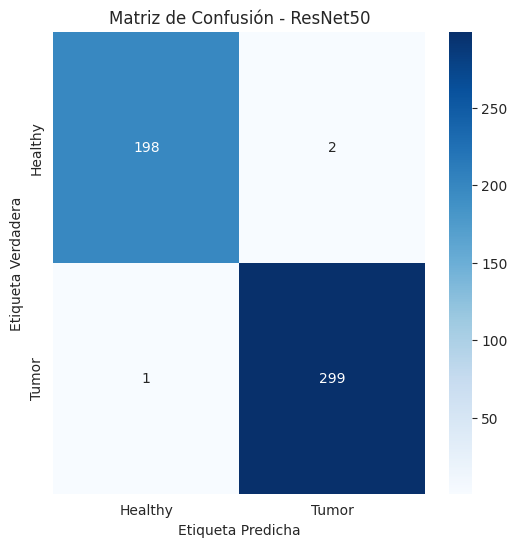


Reporte de Clasificación:
              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       200
       Tumor       0.99      1.00      1.00       300

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



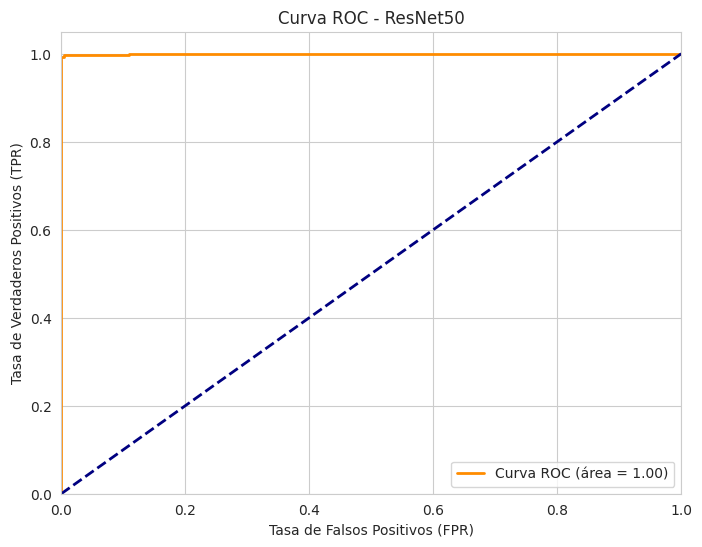

In [ ]:
# %% Evaluación del modelo
def evaluate_model(model, test_gen):
    # Reiniciar el generador de prueba para asegurar que empieza desde el principio
    test_gen.reset()
    # Evaluar el modelo en el conjunto de prueba
    loss, accuracy, auc_score = model.evaluate(test_gen, verbose=0)

    print(f"\nResultados en conjunto de prueba:")
    print(f"Pérdida (Loss): {loss:.4f}")
    print(f"Exactitud (Accuracy): {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")

    # Obtener las probabilidades predichas por el modelo para el conjunto de prueba
    y_pred_probs = model.predict(test_gen)
    # Convertir las probabilidades a predicciones de clase (0 o 1) usando un umbral de 0.5
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    # Obtener las etiquetas verdaderas del generador de prueba
    y_true = test_gen.classes

    # Obtener los nombres originales de las clases usando el label_encoder ajustado previamente
    class_names = list(label_encoder.inverse_transform([0, 1]))

    # --- Matriz de Confusión ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión - ResNet50')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

    # --- Reporte de Clasificación ---
    print("\nReporte de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # --- Curva ROC ---
    # Calcular la tasa de falsos positivos (fpr) y la tasa de verdaderos positivos (tpr)
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs) # Usar y_pred_probs para la curva ROC
    # Calcular el Área Bajo la Curva ROC
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Línea de no discriminación
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC - ResNet50')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Llamar a la función de evaluación con el modelo entrenado y el generador de prueba
evaluate_model(model, test_gen)

## 4.2 Visualización del Historial de Entrenamiento

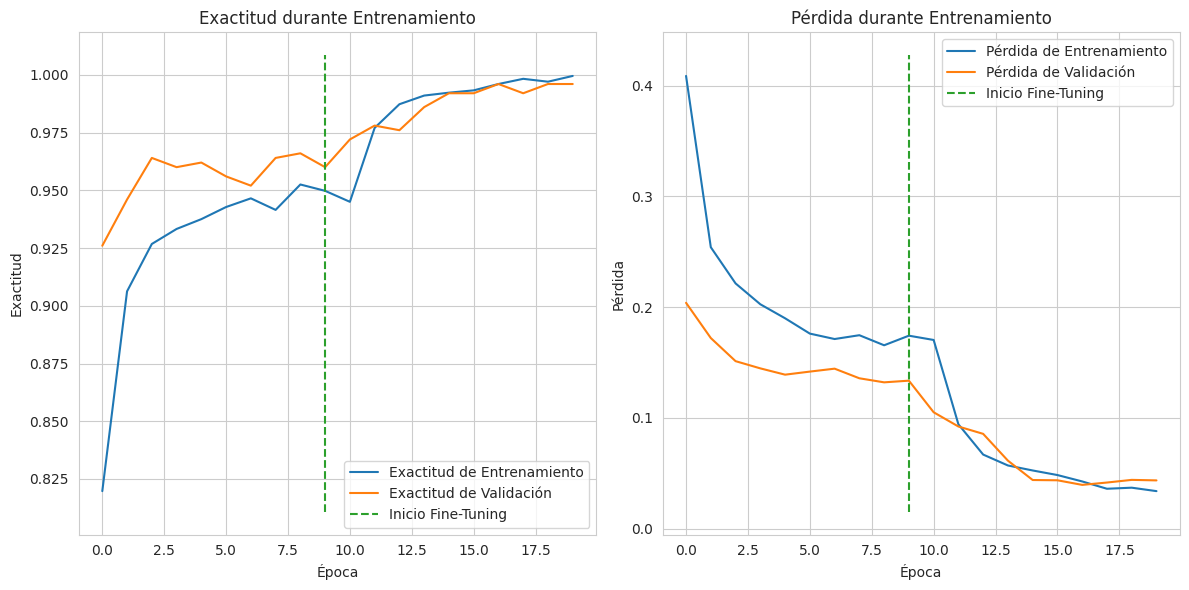

In [ ]:
# %% Visualización del historial de entrenamiento
def plot_combined_history(initial_hist, fine_tune_hist):
    # Extraer métricas de la fase inicial
    acc = initial_hist.history['accuracy']
    val_acc = initial_hist.history['val_accuracy']
    loss = initial_hist.history['loss']
    val_loss = initial_hist.history['val_loss']

    # Añadir métricas de la fase de fine-tuning
    acc += fine_tune_hist.history['accuracy']
    val_acc += fine_tune_hist.history['val_accuracy']
    loss += fine_tune_hist.history['loss']
    val_loss += fine_tune_hist.history['val_loss']

    plt.figure(figsize=(12, 6))

    # Subgráfico para la Exactitud
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Exactitud de Entrenamiento')
    plt.plot(val_acc, label='Exactitud de Validación')
    # Línea vertical para marcar el inicio del fine-tuning
    # Asumiendo que initial_epochs fue definido como en el script original
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label='Inicio Fine-Tuning', linestyle='--')
    plt.title('Exactitud durante Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.legend()
    plt.grid(True)

    # Subgráfico para la Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Pérdida de Entrenamiento')
    plt.plot(val_loss, label='Pérdida de Validación')
    # Línea vertical para marcar el inicio del fine-tuning
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label='Inicio Fine-Tuning', linestyle='--')
    plt.title('Pérdida durante Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Ajustar el layout para evitar superposiciones
    plt.show()

# Llamar a la función para graficar el historial combinado
plot_combined_history(history, history_fine)